# Ocean Dataset Test

## 10/11/25

This notebook serves as a test run of applying the previous ERA5 analysis methods to a new ERA5 dataset that has both land and ocean data.

The dataset ("ERA5 monthly averaged data on single levels from 1940 to present") is available from the following link: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview

Below are the dataset attributes:
- ERA5 monthly averaged data on single levels from 1940 to present
- Product type: Monthly averaged reanalysis
- Variables: 2m temperature, Sea surface temperature, Total precipitation
- Years: All available (1940-2025)
- Months: All months
- Time: 00:00 (Not relevent as monthly averaged reanalysis)
- Geographical area: North: 90°, West: -80°, South: 0°, East: 2° (Chosen to cover the Atlantic)
- Data format: NetCDF4
- Size: 470.31MB

The notebook is split into 3 sections:

1. Dataset Inspection
    - Inspecting the dataset files to better understand their contents and structure
1. Maps
    - Creating maps of the data
1. Linear Plots
    - Creating fitted linear plots for the variables and looking for trends

## 1. Data Inspection

Unlike previous datasets, this one downloaded in the form two seperate files. The first task is to figure out what each file contains.

Having imported the relevant modules, I opened each file using xarray and printed them.

The results below show that one of the files contains the variables 2m temperature and sea surface temperature and the other file contains the precipitation variable.

The files have the same format as the previous datasets so the code can follow closely the previous notebooks.

In [2]:
# Importing modules
import xarray as xr
import regionmask
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Specifying file paths
file_path_a = r"C:\Users\itsna\OneDrive\Desktop\MSc Work\DataSets\data_stream-moda_stepType-avgad.nc"
file_path_b = r"C:\Users\itsna\OneDrive\Desktop\MSc Work\DataSets\data_stream-moda_stepType-avgua.nc"

# Printing each file
print(xr.open_dataset(file_path_a))
print(xr.open_dataset(file_path_b))

<xarray.Dataset> Size: 489MB
Dimensions:     (valid_time: 1030, latitude: 361, longitude: 329)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2025-...
  * latitude    (latitude) float64 3kB 90.0 89.75 89.5 89.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 3kB -80.0 -79.75 -79.5 ... 1.5 1.75 2.0
    expver      (valid_time) <U4 16kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 489MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-12T15:10 GRIB to CDM+CF via cfgrib-0.9.1...
<xarray.Dataset> Size: 979MB
Dimensions:     (valid_time: 1030, latitude: 361, longitude: 329)
Coordinates:
    number      int64 8B ...
  * valid_t

## 2.0. Maps

With the files better understood I then created the first maps from this new dataset. To keep things simple I initially just created one for 2m temp covering the entire area.

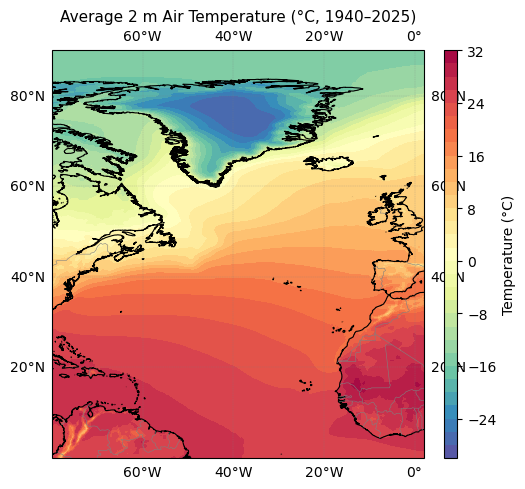

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np

# Loading dataset
ds = xr.open_dataset(file_path_b)

# Converting to celsius and averaging
t2m_c = ds["t2m"] - 273.15
t2m_mean = t2m_c.mean(dim="valid_time", skipna=True)

# Extracting coordinates
lon = ds["longitude"]
lat = ds["latitude"]

# Creating map
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={"projection": proj})

# Plotting avg temp
contour = ax.contourf(
    lon, lat, t2m_mean,
    transform=proj,
    cmap="Spectral_r",  # colourmap for temp
    levels=30
)

# Map settings
ax.set_extent([-80, 2, 0, 90])  # Atlantic region
ax.coastlines(resolution="10m", color="black", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor="gray")
ax.gridlines(draw_labels=True, linewidth=0.3, linestyle="--", color="gray", alpha=0.5)

ax.set_title("Average 2 m Air Temperature (°C, 1940–2025)", fontsize=11)

# Colourbar
cbar = plt.colorbar(contour, orientation="vertical", pad=0.03, aspect=30)
cbar.set_label("Temperature (°C)", fontsize=10)

plt.tight_layout()
plt.show()


It's cool that this value seems to cover both ocean and land, perhaps making the previous ERA5-Land dataset obsolete. It might be worth comparing the two datasets with eachother. With a simple map done I then moved on to making a map for precipitation and 2m temp side-by-side.

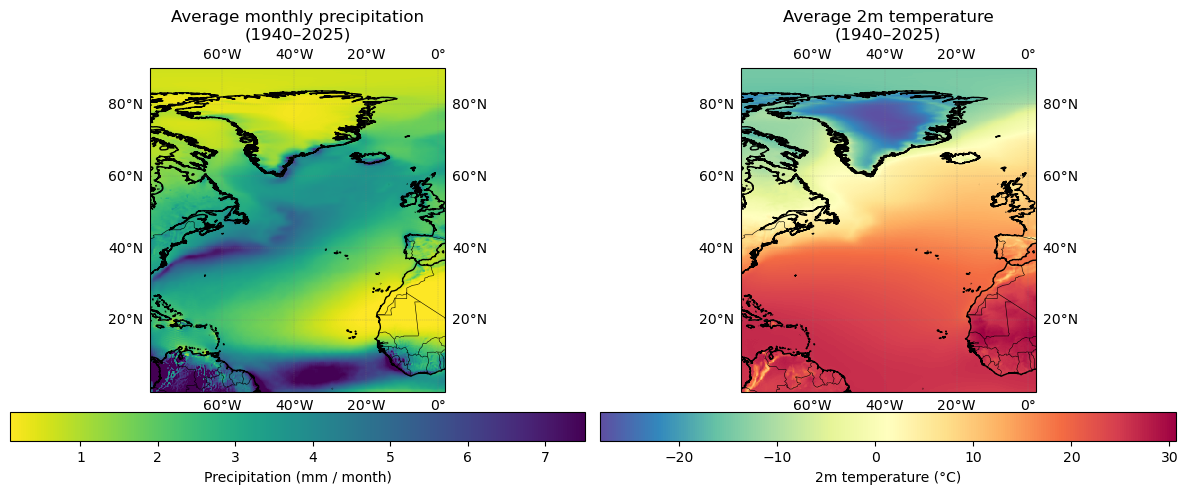

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import pandas as pd

# Choosing colour maps
precip_cmap = "viridis_r"
temp_cmap   = "Spectral_r"

ds_precip = xr.open_dataset(file_path_a)
ds_temp   = xr.open_dataset(file_path_b)

time_name = "valid_time"
lat_name  = "latitude"
lon_name  = "longitude"

# Precip
tp = ds_precip["tp"]

# Converting to mm and avg over time
tp_mm = tp * 1000.0
tp_clim = tp_mm.mean(dim=time_name, skipna=True)

# 2m temperature avg
t2m_clim = (ds_temp["t2m"] - 273.15).mean(dim=time_name, skipna=True)

lats = ds_temp[lat_name]
lons = ds_temp[lon_name]
proj = ccrs.PlateCarree()

# Making colourscales (ignoring outliers to increase contrast)
p2, p98 = np.nanpercentile(tp_clim.values, [2, 98])
if not np.isfinite(p2) or not np.isfinite(p98) or p98 <= p2:
    vmin, vmax = float(np.nanmin(tp_clim)), float(np.nanmax(tp_clim))
else:
    vmin, vmax = p2, p98

start_year = pd.to_datetime(ds_precip[time_name].values[0]).year
end_year   = pd.to_datetime(ds_precip[time_name].values[-1]).year

fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": proj})

# Precipitation plot
ax = axes[0]
pc = ax.pcolormesh(lons, lats, tp_clim, cmap=precip_cmap, transform=proj, shading="auto",
                   vmin=vmin, vmax=vmax)
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.set_extent([-80, 2, 0, 90], crs=proj)
cb = plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05)
cb.set_label("Precipitation (mm / month)")
ax.set_title(f"Average monthly precipitation\n({start_year}–{end_year})")
ax.gridlines(draw_labels=True, linewidth=0.3, linestyle="--", color="gray", alpha=0.5)

# Temperature plot
ax = axes[1]
pc2 = ax.pcolormesh(lons, lats, t2m_clim, cmap=temp_cmap, transform=proj, shading="auto")
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.set_extent([-80, 2, 0, 90], crs=proj)
cb2 = plt.colorbar(pc2, ax=ax, orientation="horizontal", pad=0.05)
cb2.set_label("2m temperature (°C)")
ax.set_title(f"Average 2m temperature\n({start_year}–{end_year})")
ax.gridlines(draw_labels=True, linewidth=0.3, linestyle="--", color="gray", alpha=0.5)

plt.tight_layout()
plt.show()


These two plots create a good picture of the temperature and precipitation patterns over the atlantic. The heaviest precipitation seems to follow the border between cold and hot air (which is to be expected) with some heavy precipitation down towards the equator also.

I then created plots for 2m air temperature and seas surface temperature side-by-side to compare. We should expect that they follow eachother very closely.

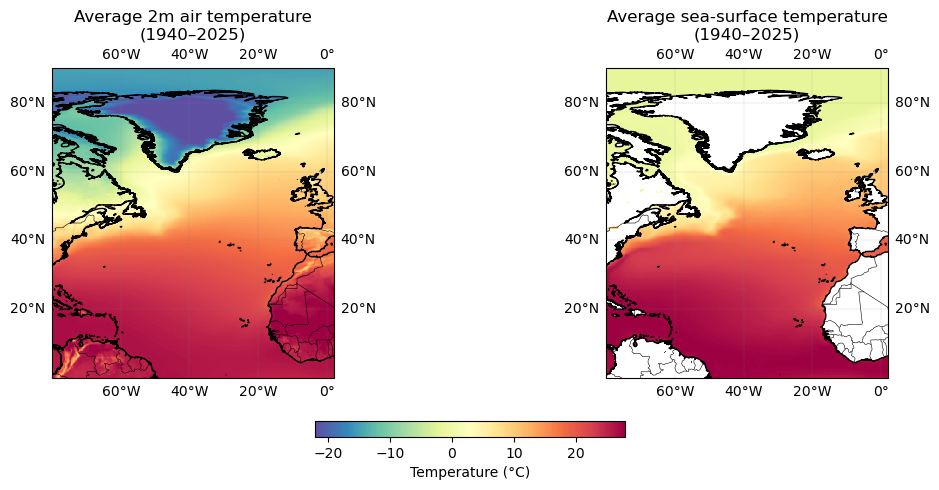

In [3]:
# Importing relevant modules
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import pandas as pd

temp_path = file_path_b

ds = xr.open_dataset(temp_path)

time_name = "valid_time"
lat_name  = "latitude"
lon_name  = "longitude"

# Convering to celsius
t2m_c   = ds["t2m"] - 273.15
sst_c   = ds["sst"] - 273.15

# Avg over time
t2m_clim = t2m_c.mean(dim=time_name, skipna=True)
sst_clim = sst_c.mean(dim=time_name, skipna=True)

# Shared colour (removing outliers)
stack = np.concatenate([t2m_clim.values.ravel(), sst_clim.values.ravel()])
tmin, tmax = np.nanpercentile(stack, [2, 98])
if not np.isfinite(tmin) or not np.isfinite(tmax) or tmax <= tmin:
    tmin, tmax = float(np.nanmin(stack)), float(np.nanmax(stack))

# Map setup
proj   = ccrs.PlateCarree()
extent = [-80, 2, 0, 90]
lats   = ds[lat_name]
lons   = ds[lon_name]

# Years for titles
t_vals = pd.to_datetime(ds[time_name].values)
start_year, end_year = t_vals[0].year, t_vals[-1].year

# Plot layout
fig, axes = plt.subplots(
    1, 2,
    figsize=(11, 4.8),
    subplot_kw={"projection": proj},
    constrained_layout=True,
    gridspec_kw={"wspace": 0.03}
)


# t2m plot
pc1 = axes[0].pcolormesh(
    lons, lats, t2m_clim,
    cmap="Spectral_r", vmin=tmin, vmax=tmax,
    transform=proj, shading="auto"
)
axes[0].coastlines("10m")
axes[0].add_feature(cfeature.BORDERS, linewidth=0.4)
axes[0].set_extent(extent)
axes[0].set_title(f"Average 2m air temperature\n({start_year}–{end_year})")
axes[0].gridlines(draw_labels=True, linewidth=0.3, linestyle="--", color="gray", alpha=0.5)

# SST plot
pc2 = axes[1].pcolormesh(
    lons, lats, sst_clim,
    cmap="Spectral_r", vmin=tmin, vmax=tmax,
    transform=proj, shading="auto"
)
axes[1].coastlines("10m")
axes[1].add_feature(cfeature.BORDERS, linewidth=0.4)
axes[1].set_extent(extent)
axes[1].set_title(f"Average sea-surface temperature\n({start_year}–{end_year})")
axes[1].gridlines(draw_labels=True, linewidth=0.3, linestyle="--", color="gray", alpha=0.5)

# Shared colourbar
cbar = fig.colorbar(pc2, ax=axes, orientation="horizontal", fraction=0.05, pad=0.07)
cbar.set_label("Temperature (°C)")

plt.show()

As expected the two values correlate closely, although in the north sea-surface temp seems to be higher than 2m temp.

I then wanted to see how the seasons affect each value. To do this I recreated the plot above for each season, with one shared colourbar.

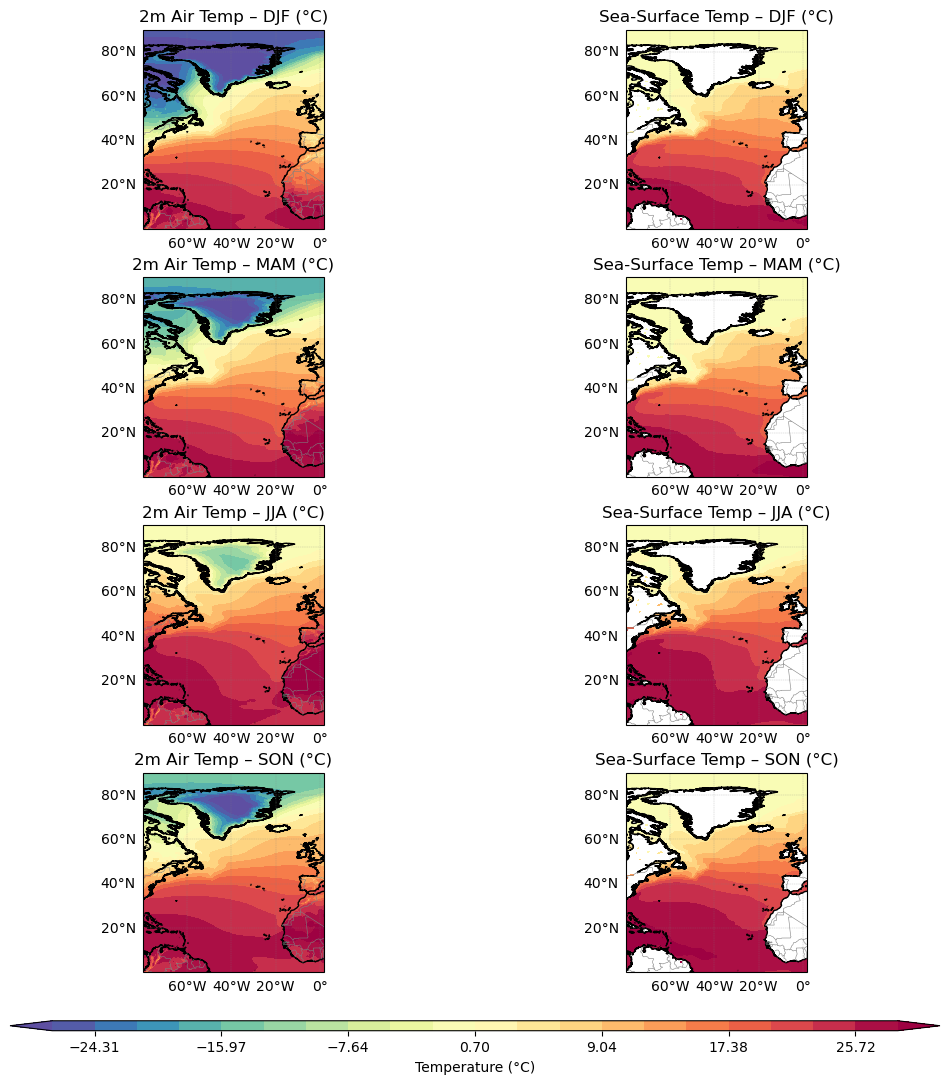

In [29]:
# Importing relevant modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np

colour_map = "Spectral_r"

ds = xr.open_dataset(file_path_b)

time_name = "valid_time"
lat_name  = "latitude"
lon_name  = "longitude"

# Converting to celsius
t2mC = ds["t2m"] - 273.15
sstC = ds["sst"] - 273.15

# Calculating avg
def season_mean(da, months):
    return da.where(da[time_name].dt.month.isin(months), drop=True).mean(time_name, skipna=True)

# Seasons
t2m_DJF = season_mean(t2mC, [12, 1,  2])
t2m_MAM = season_mean(t2mC, [3,  4,  5])
t2m_JJA = season_mean(t2mC, [6,  7,  8])
t2m_SON = season_mean(t2mC, [9, 10, 11])

sst_DJF = season_mean(sstC, [12, 1,  2])
sst_MAM = season_mean(sstC, [3,  4,  5])
sst_JJA = season_mean(sstC, [6,  7,  8])
sst_SON = season_mean(sstC, [9, 10, 11])

# Creating shared colour values
stack = np.concatenate([
    t2m_DJF.values.ravel(), t2m_MAM.values.ravel(),
    t2m_JJA.values.ravel(), t2m_SON.values.ravel(),
    sst_DJF.values.ravel(), sst_MAM.values.ravel(),
    sst_JJA.values.ravel(), sst_SON.values.ravel()
])
vmin = np.nanpercentile(stack, 2)
vmax = np.nanpercentile(stack, 98)
levels = np.linspace(vmin, vmax, 21)

# Extracting lon/lat for plotting
lon = ds[lon_name]
lat = ds[lat_name]

# Making a new GeoAxes with lat/lon projection
proj = ccrs.PlateCarree()

# Setting the plotted area
extent = [-80, 2, 0, 90]

# Setting layout of plots
fig = plt.figure(figsize=(12, 13), constrained_layout=False)
gs = fig.add_gridspec(nrows=5, ncols=2,
                      height_ratios=[20, 20, 20, 20, 1],
                      hspace=0.3, wspace=0.08) # Making more space to stop overlapping titles

# Map axes
ax_DJF_t2m = fig.add_subplot(gs[0, 0], projection=proj)
ax_DJF_sst = fig.add_subplot(gs[0, 1], projection=proj)

ax_MAM_t2m = fig.add_subplot(gs[1, 0], projection=proj)
ax_MAM_sst = fig.add_subplot(gs[1, 1], projection=proj)

ax_JJA_t2m = fig.add_subplot(gs[2, 0], projection=proj)
ax_JJA_sst = fig.add_subplot(gs[2, 1], projection=proj)

ax_SON_t2m = fig.add_subplot(gs[3, 0], projection=proj)
ax_SON_sst = fig.add_subplot(gs[3, 1], projection=proj)

# Colourbar
cax = fig.add_subplot(gs[4, :])

axes_grid = [
    [ax_DJF_t2m, ax_DJF_sst],
    [ax_MAM_t2m, ax_MAM_sst],
    [ax_JJA_t2m, ax_JJA_sst],
    [ax_SON_t2m, ax_SON_sst],
]

# Settings for the maps
for i, row in enumerate(axes_grid):
    for j, ax in enumerate(row):
        ax.set_extent(extent, crs=proj)
        ax.coastlines(resolution="10m", color="black")
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor="gray")

        # Making gridlines only appear on left and bottom of plot
        gl = ax.gridlines(
            draw_labels=True,
            linewidth=0.3,
            linestyle="--",
            color="gray",
            alpha=0.5,
            x_inline=False,
            y_inline=False,
        )
        gl.top_labels = False
        gl.right_labels = False


# Plotting each panel
cs_DJF_t2m = ax_DJF_t2m.contourf(lon, lat, t2m_DJF, levels=levels, cmap=colour_map,
                                 transform=proj, extend='both')
ax_DJF_t2m.set_title("2m Air Temp – DJF (°C)")

cs_DJF_sst = ax_DJF_sst.contourf(lon, lat, sst_DJF, levels=levels, cmap=colour_map,
                                 transform=proj, extend='both')
ax_DJF_sst.set_title("Sea-Surface Temp – DJF (°C)")

cs_MAM_t2m = ax_MAM_t2m.contourf(lon, lat, t2m_MAM, levels=levels, cmap=colour_map,
                                 transform=proj, extend='both')
ax_MAM_t2m.set_title("2m Air Temp – MAM (°C)")

cs_MAM_sst = ax_MAM_sst.contourf(lon, lat, sst_MAM, levels=levels, cmap=colour_map,
                                 transform=proj, extend='both')
ax_MAM_sst.set_title("Sea-Surface Temp – MAM (°C)")

cs_JJA_t2m = ax_JJA_t2m.contourf(lon, lat, t2m_JJA, levels=levels, cmap=colour_map,
                                 transform=proj, extend='both')
ax_JJA_t2m.set_title("2m Air Temp – JJA (°C)")

cs_JJA_sst = ax_JJA_sst.contourf(lon, lat, sst_JJA, levels=levels, cmap=colour_map,
                                 transform=proj, extend='both')
ax_JJA_sst.set_title("Sea-Surface Temp – JJA (°C)")

cs_SON_t2m = ax_SON_t2m.contourf(lon, lat, t2m_SON, levels=levels, cmap=colour_map,
                                 transform=proj, extend='both')
ax_SON_t2m.set_title("2m Air Temp – SON (°C)")

cs_SON_sst = ax_SON_sst.contourf(lon, lat, sst_SON, levels=levels, cmap=colour_map,
                                 transform=proj, extend='both')
ax_SON_sst.set_title("Sea-Surface Temp – SON (°C)")

# Shared colour-bar
cb = fig.colorbar(cs_SON_sst, cax=cax, orientation="horizontal")
cb.set_label("Temperature (°C)")

plt.show()



From the big picture, it seems that the sea-surface temperature is not as affected by the seasons as the 2m air temperature. On this scale, however, it's difficult to see small changes in temperature. For this reason I then adjusted the code to easily zoom in on smaller geographical areas, ensuring the colourbar is adjusted to reflect only the value in the area selected (this way a greater resolution is achieved).

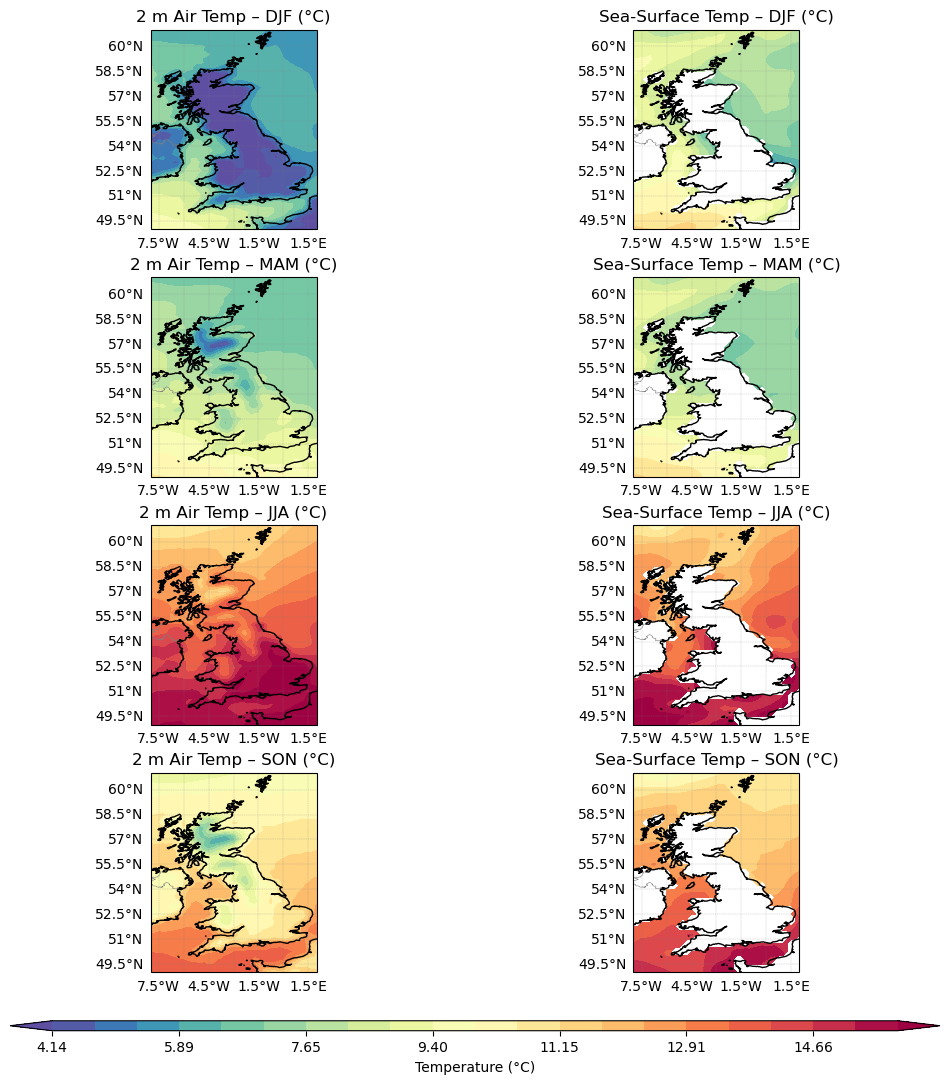

In [31]:
# Importing relevant modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np

# Choosing colourmap
colour_map = "Spectral_r"

# Opening temp dataset
ds = xr.open_dataset(file_path_b)

# Variable and coordinate names
time_name = "valid_time"
lat_name  = "latitude"
lon_name  = "longitude"
t2m_name  = "t2m"
sst_name = "sst"

# Converting to celsius
t2mC = t2mK - 273.15
sstC = sstK - 273.15

# Calculating seasonal avg
def season_mean(da, months):
    return da.where(da[time_name].dt.month.isin(months), drop=True).mean(time_name, skipna=True)

# Seasons for 2m temp
t2m_DJF = season_mean(t2mC, [12, 1,  2])
t2m_MAM = season_mean(t2mC, [3,  4,  5])
t2m_JJA = season_mean(t2mC, [6,  7,  8])
t2m_SON = season_mean(t2mC, [9, 10, 11])

# Seasons for sst
sst_DJF = season_mean(sstC, [12, 1,  2])
sst_MAM = season_mean(sstC, [3,  4,  5])
sst_JJA = season_mean(sstC, [6,  7,  8])
sst_SON = season_mean(sstC, [9, 10, 11])

# Setting region
lon_min, lon_max = -8, 2
lat_min, lat_max = 49, 61

# Atlantic:
# lon_min, lon_max = -80, 2
# lat_min, lat_max = 0, 90

# Func to help adjust errorbars based on new area
def crop_to_region(da, lon_min, lon_max, lat_min, lat_max):
    lats = da[lat_name]
    lons = da[lon_name]

    # Latitude slice
    if lats[0] < lats[-1]:
        lat_slice = slice(lat_min, lat_max)
    else:
        lat_slice = slice(lat_max, lat_min)

    # Longitude slice
    if lons[0] < lons[-1]:
        lon_slice = slice(lon_min, lon_max)
    else:
        lon_slice = slice(lon_max, lon_min)

    return da.sel({lat_name: lat_slice, lon_name: lon_slice})

# Cropping seasonal fields to region
t2m_DJF_reg = crop_to_region(t2m_DJF, lon_min, lon_max, lat_min, lat_max)
t2m_MAM_reg = crop_to_region(t2m_MAM, lon_min, lon_max, lat_min, lat_max)
t2m_JJA_reg = crop_to_region(t2m_JJA, lon_min, lon_max, lat_min, lat_max)
t2m_SON_reg = crop_to_region(t2m_SON, lon_min, lon_max, lat_min, lat_max)

sst_DJF_reg = crop_to_region(sst_DJF, lon_min, lon_max, lat_min, lat_max)
sst_MAM_reg = crop_to_region(sst_MAM, lon_min, lon_max, lat_min, lat_max)
sst_JJA_reg = crop_to_region(sst_JJA, lon_min, lon_max, lat_min, lat_max)
sst_SON_reg = crop_to_region(sst_SON, lon_min, lon_max, lat_min, lat_max)

# Creating shared colour limits from cropped fields
stack = np.concatenate([
    t2m_DJF_reg.values.ravel(), t2m_MAM_reg.values.ravel(),
    t2m_JJA_reg.values.ravel(), t2m_SON_reg.values.ravel(),
    sst_DJF_reg.values.ravel(), sst_MAM_reg.values.ravel(),
    sst_JJA_reg.values.ravel(), sst_SON_reg.values.ravel()
])
vmin = np.nanpercentile(stack, 2)
vmax = np.nanpercentile(stack, 98)
levels = np.linspace(vmin, vmax, 21)

# Extracting lon/lat for plotting
lon_reg = t2m_DJF_reg[lon_name]
lat_reg = t2m_DJF_reg[lat_name]

# Choosing map projection
proj = ccrs.PlateCarree()

# Setting layout of plots
fig = plt.figure(figsize=(12, 13), constrained_layout=False)
gs = fig.add_gridspec(
    nrows=5, ncols=2,
    height_ratios=[20, 20, 20, 20, 1],
    hspace=0.3, wspace=0.08  # Extra space to reduce overlap
)

# Axes
ax_DJF_t2m = fig.add_subplot(gs[0, 0], projection=proj)
ax_DJF_sst = fig.add_subplot(gs[0, 1], projection=proj)

ax_MAM_t2m = fig.add_subplot(gs[1, 0], projection=proj)
ax_MAM_sst = fig.add_subplot(gs[1, 1], projection=proj)

ax_JJA_t2m = fig.add_subplot(gs[2, 0], projection=proj)
ax_JJA_sst = fig.add_subplot(gs[2, 1], projection=proj)

ax_SON_t2m = fig.add_subplot(gs[3, 0], projection=proj)
ax_SON_sst = fig.add_subplot(gs[3, 1], projection=proj)

# Colourbar axis
cax = fig.add_subplot(gs[4, :])

# Grouping axes by row for labels
axes_grid = [
    [ax_DJF_t2m, ax_DJF_sst],
    [ax_MAM_t2m, ax_MAM_sst],
    [ax_JJA_t2m, ax_JJA_sst],
    [ax_SON_t2m, ax_SON_sst],
]

# Layout and map settings
for i, row in enumerate(axes_grid):
    for j, ax in enumerate(row):
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
        ax.coastlines(resolution="10m", color="black")
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor="gray")

        # Adding gridlines (labels only on left column and bottom row)
        gl = ax.gridlines(
            draw_labels=True,
            linewidth=0.3,
            linestyle="--",
            color="gray",
            alpha=0.5,
            x_inline=False,
            y_inline=False,
        )
        gl.top_labels = False
        gl.right_labels = False

# Plotting each seasonal panel
cs_DJF_t2m = ax_DJF_t2m.contourf(
    lon_reg, lat_reg, t2m_DJF_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_DJF_t2m.set_title("2 m Air Temp – DJF (°C)")

cs_DJF_sst = ax_DJF_sst.contourf(
    lon_reg, lat_reg, sst_DJF_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_DJF_sst.set_title("Sea-Surface Temp – DJF (°C)")

cs_MAM_t2m = ax_MAM_t2m.contourf(
    lon_reg, lat_reg, t2m_MAM_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_MAM_t2m.set_title("2 m Air Temp – MAM (°C)")

cs_MAM_sst = ax_MAM_sst.contourf(
    lon_reg, lat_reg, sst_MAM_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_MAM_sst.set_title("Sea-Surface Temp – MAM (°C)")

cs_JJA_t2m = ax_JJA_t2m.contourf(
    lon_reg, lat_reg, t2m_JJA_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_JJA_t2m.set_title("2 m Air Temp – JJA (°C)")

cs_JJA_sst = ax_JJA_sst.contourf(
    lon_reg, lat_reg, sst_JJA_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_JJA_sst.set_title("Sea-Surface Temp – JJA (°C)")

cs_SON_t2m = ax_SON_t2m.contourf(
    lon_reg, lat_reg, t2m_SON_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_SON_t2m.set_title("2 m Air Temp – SON (°C)")

cs_SON_sst = ax_SON_sst.contourf(
    lon_reg, lat_reg, sst_SON_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_SON_sst.set_title("Sea-Surface Temp – SON (°C)")

# Shared colourbar
cb = fig.colorbar(cs_SON_sst, cax=cax, orientation="horizontal")
cb.set_label("Temperature (°C)")

plt.show()


Initially I chose to zoom in on the UK. On this small scale we can see that actually sea-surface and 2m air temperatures (at least around the UK) are both heavily affected by season. I then seperated the atlanic into two halves, north and south.

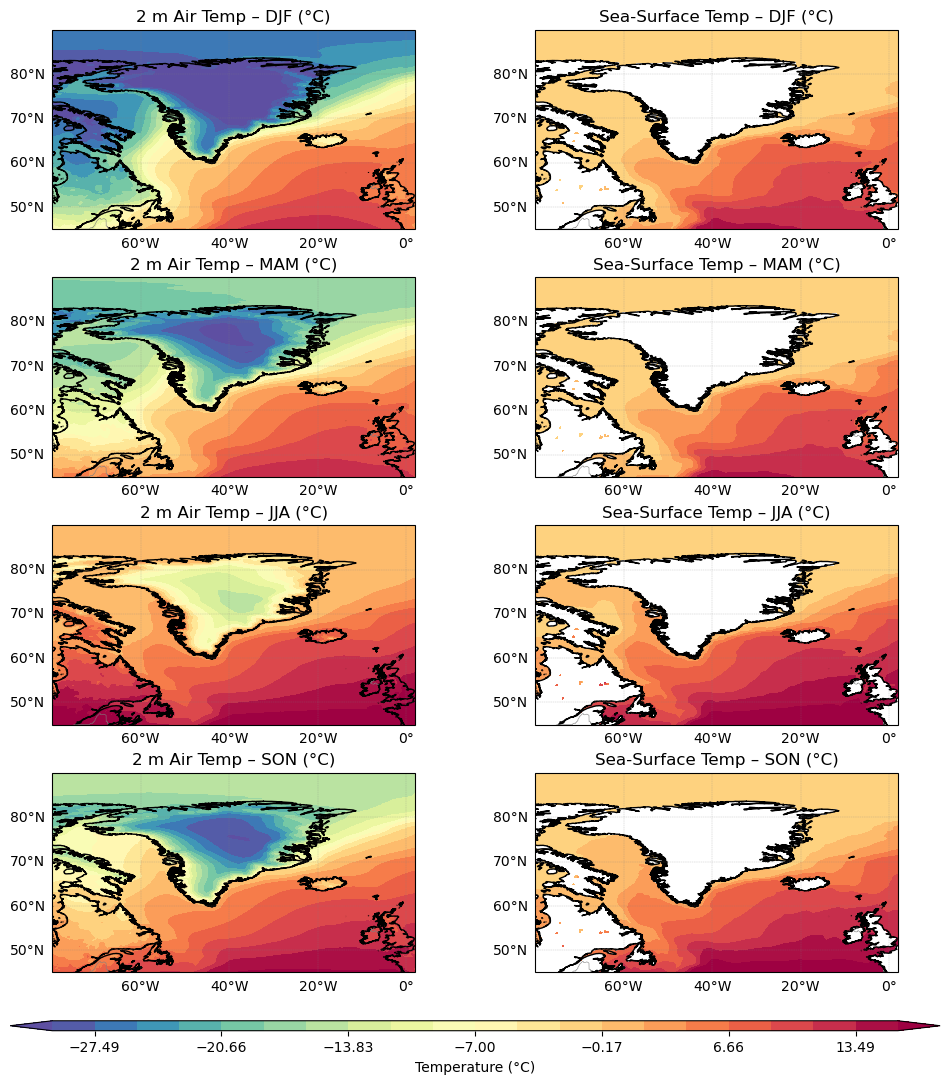

In [32]:
# Importing relevant modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np

# Choosing colourmap
colour_map = "Spectral_r"

# Opening temp dataset
ds = xr.open_dataset(file_path_b)

# Variable and coordinate names
time_name = "valid_time"
lat_name  = "latitude"
lon_name  = "longitude"
t2m_name  = "t2m"
sst_name = "sst"

# Converting to celsius
t2mC = t2mK - 273.15
sstC = sstK - 273.15

# Calculating seasonal avg
def season_mean(da, months):
    return da.where(da[time_name].dt.month.isin(months), drop=True).mean(time_name, skipna=True)

# Seasons for 2m temp
t2m_DJF = season_mean(t2mC, [12, 1,  2])
t2m_MAM = season_mean(t2mC, [3,  4,  5])
t2m_JJA = season_mean(t2mC, [6,  7,  8])
t2m_SON = season_mean(t2mC, [9, 10, 11])

# Seasons for sst
sst_DJF = season_mean(sstC, [12, 1,  2])
sst_MAM = season_mean(sstC, [3,  4,  5])
sst_JJA = season_mean(sstC, [6,  7,  8])
sst_SON = season_mean(sstC, [9, 10, 11])

# Setting region
lon_min, lon_max = -80, 2
lat_min, lat_max = 45, 90

# Atlantic:
# lon_min, lon_max = -80, 2
# lat_min, lat_max = 0, 90

# Func to help adjust errorbars based on new area
def crop_to_region(da, lon_min, lon_max, lat_min, lat_max):
    lats = da[lat_name]
    lons = da[lon_name]

    # Latitude slice
    if lats[0] < lats[-1]:
        lat_slice = slice(lat_min, lat_max)
    else:
        lat_slice = slice(lat_max, lat_min)

    # Longitude slice
    if lons[0] < lons[-1]:
        lon_slice = slice(lon_min, lon_max)
    else:
        lon_slice = slice(lon_max, lon_min)

    return da.sel({lat_name: lat_slice, lon_name: lon_slice})

# Cropping seasonal fields to region
t2m_DJF_reg = crop_to_region(t2m_DJF, lon_min, lon_max, lat_min, lat_max)
t2m_MAM_reg = crop_to_region(t2m_MAM, lon_min, lon_max, lat_min, lat_max)
t2m_JJA_reg = crop_to_region(t2m_JJA, lon_min, lon_max, lat_min, lat_max)
t2m_SON_reg = crop_to_region(t2m_SON, lon_min, lon_max, lat_min, lat_max)

sst_DJF_reg = crop_to_region(sst_DJF, lon_min, lon_max, lat_min, lat_max)
sst_MAM_reg = crop_to_region(sst_MAM, lon_min, lon_max, lat_min, lat_max)
sst_JJA_reg = crop_to_region(sst_JJA, lon_min, lon_max, lat_min, lat_max)
sst_SON_reg = crop_to_region(sst_SON, lon_min, lon_max, lat_min, lat_max)

# Creating shared colour limits from cropped fields
stack = np.concatenate([
    t2m_DJF_reg.values.ravel(), t2m_MAM_reg.values.ravel(),
    t2m_JJA_reg.values.ravel(), t2m_SON_reg.values.ravel(),
    sst_DJF_reg.values.ravel(), sst_MAM_reg.values.ravel(),
    sst_JJA_reg.values.ravel(), sst_SON_reg.values.ravel()
])
vmin = np.nanpercentile(stack, 2)
vmax = np.nanpercentile(stack, 98)
levels = np.linspace(vmin, vmax, 21)

# Extracting lon/lat for plotting
lon_reg = t2m_DJF_reg[lon_name]
lat_reg = t2m_DJF_reg[lat_name]

# Choosing map projection
proj = ccrs.PlateCarree()

# Setting layout of plots
fig = plt.figure(figsize=(12, 13), constrained_layout=False)
gs = fig.add_gridspec(
    nrows=5, ncols=2,
    height_ratios=[20, 20, 20, 20, 1],
    hspace=0.3, wspace=0.08  # Extra space to reduce overlap
)

# Axes
ax_DJF_t2m = fig.add_subplot(gs[0, 0], projection=proj)
ax_DJF_sst = fig.add_subplot(gs[0, 1], projection=proj)

ax_MAM_t2m = fig.add_subplot(gs[1, 0], projection=proj)
ax_MAM_sst = fig.add_subplot(gs[1, 1], projection=proj)

ax_JJA_t2m = fig.add_subplot(gs[2, 0], projection=proj)
ax_JJA_sst = fig.add_subplot(gs[2, 1], projection=proj)

ax_SON_t2m = fig.add_subplot(gs[3, 0], projection=proj)
ax_SON_sst = fig.add_subplot(gs[3, 1], projection=proj)

# Colourbar axis
cax = fig.add_subplot(gs[4, :])

# Grouping axes by row for labels
axes_grid = [
    [ax_DJF_t2m, ax_DJF_sst],
    [ax_MAM_t2m, ax_MAM_sst],
    [ax_JJA_t2m, ax_JJA_sst],
    [ax_SON_t2m, ax_SON_sst],
]

# Layout and map settings
for i, row in enumerate(axes_grid):
    for j, ax in enumerate(row):
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
        ax.coastlines(resolution="10m", color="black")
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor="gray")

        # Adding gridlines (labels only on left column and bottom row)
        gl = ax.gridlines(
            draw_labels=True,
            linewidth=0.3,
            linestyle="--",
            color="gray",
            alpha=0.5,
            x_inline=False,
            y_inline=False,
        )
        gl.top_labels = False
        gl.right_labels = False

# Plotting each seasonal panel
cs_DJF_t2m = ax_DJF_t2m.contourf(
    lon_reg, lat_reg, t2m_DJF_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_DJF_t2m.set_title("2 m Air Temp – DJF (°C)")

cs_DJF_sst = ax_DJF_sst.contourf(
    lon_reg, lat_reg, sst_DJF_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_DJF_sst.set_title("Sea-Surface Temp – DJF (°C)")

cs_MAM_t2m = ax_MAM_t2m.contourf(
    lon_reg, lat_reg, t2m_MAM_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_MAM_t2m.set_title("2 m Air Temp – MAM (°C)")

cs_MAM_sst = ax_MAM_sst.contourf(
    lon_reg, lat_reg, sst_MAM_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_MAM_sst.set_title("Sea-Surface Temp – MAM (°C)")

cs_JJA_t2m = ax_JJA_t2m.contourf(
    lon_reg, lat_reg, t2m_JJA_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_JJA_t2m.set_title("2 m Air Temp – JJA (°C)")

cs_JJA_sst = ax_JJA_sst.contourf(
    lon_reg, lat_reg, sst_JJA_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_JJA_sst.set_title("Sea-Surface Temp – JJA (°C)")

cs_SON_t2m = ax_SON_t2m.contourf(
    lon_reg, lat_reg, t2m_SON_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_SON_t2m.set_title("2 m Air Temp – SON (°C)")

cs_SON_sst = ax_SON_sst.contourf(
    lon_reg, lat_reg, sst_SON_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_SON_sst.set_title("Sea-Surface Temp – SON (°C)")

# Shared colourbar
cb = fig.colorbar(cs_SON_sst, cax=cax, orientation="horizontal")
cb.set_label("Temperature (°C)")

plt.show()


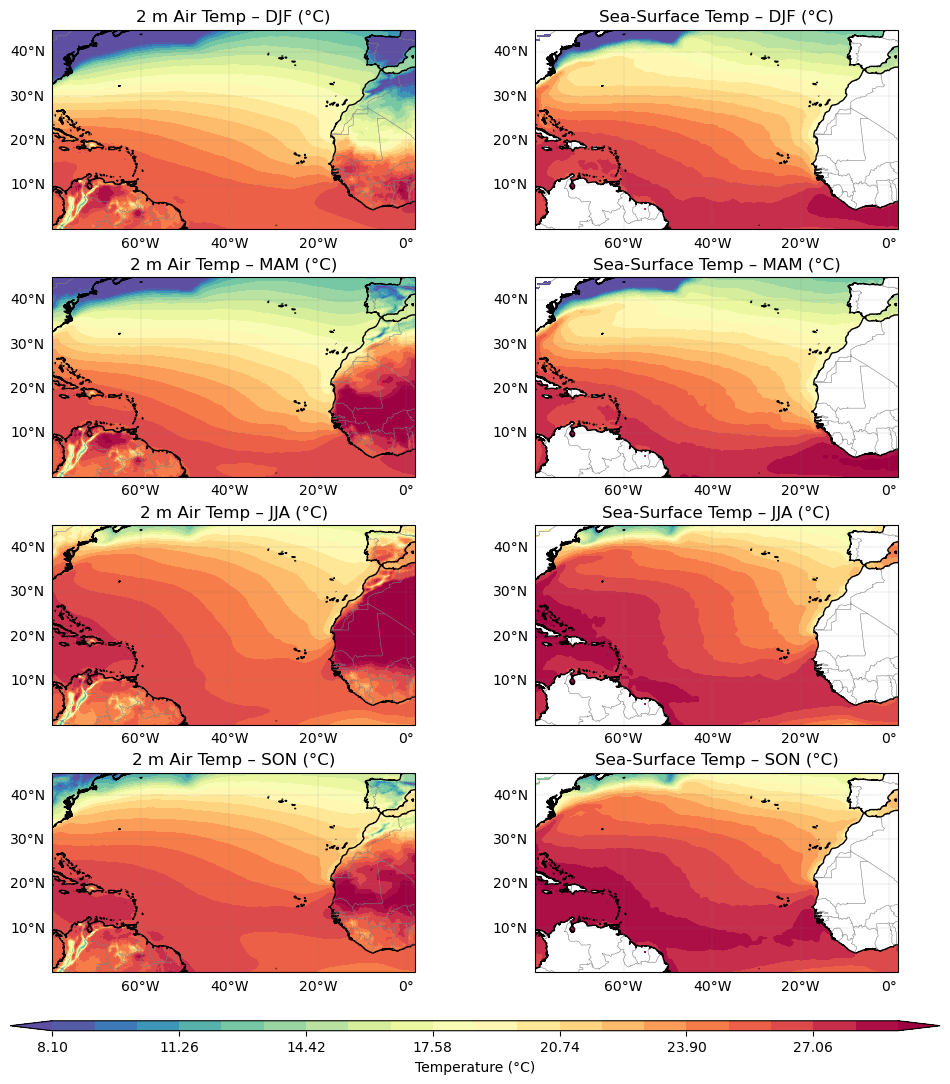

In [33]:
# Importing relevant modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np

# Choosing colourmap
colour_map = "Spectral_r"

# Opening temp dataset
ds = xr.open_dataset(file_path_b)

# Variable and coordinate names
time_name = "valid_time"
lat_name  = "latitude"
lon_name  = "longitude"
t2m_name  = "t2m"
sst_name = "sst"

# Converting to celsius
t2mC = t2mK - 273.15
sstC = sstK - 273.15

# Calculating seasonal avg
def season_mean(da, months):
    return da.where(da[time_name].dt.month.isin(months), drop=True).mean(time_name, skipna=True)

# Seasons for 2m temp
t2m_DJF = season_mean(t2mC, [12, 1,  2])
t2m_MAM = season_mean(t2mC, [3,  4,  5])
t2m_JJA = season_mean(t2mC, [6,  7,  8])
t2m_SON = season_mean(t2mC, [9, 10, 11])

# Seasons for sst
sst_DJF = season_mean(sstC, [12, 1,  2])
sst_MAM = season_mean(sstC, [3,  4,  5])
sst_JJA = season_mean(sstC, [6,  7,  8])
sst_SON = season_mean(sstC, [9, 10, 11])

# Setting region
lon_min, lon_max = -80, 2
lat_min, lat_max = 0, 45

# Atlantic:
# lon_min, lon_max = -80, 2
# lat_min, lat_max = 0, 90

# Func to help adjust errorbars based on new area
def crop_to_region(da, lon_min, lon_max, lat_min, lat_max):
    lats = da[lat_name]
    lons = da[lon_name]

    # Latitude slice
    if lats[0] < lats[-1]:
        lat_slice = slice(lat_min, lat_max)
    else:
        lat_slice = slice(lat_max, lat_min)

    # Longitude slice
    if lons[0] < lons[-1]:
        lon_slice = slice(lon_min, lon_max)
    else:
        lon_slice = slice(lon_max, lon_min)

    return da.sel({lat_name: lat_slice, lon_name: lon_slice})

# Cropping seasonal fields to region
t2m_DJF_reg = crop_to_region(t2m_DJF, lon_min, lon_max, lat_min, lat_max)
t2m_MAM_reg = crop_to_region(t2m_MAM, lon_min, lon_max, lat_min, lat_max)
t2m_JJA_reg = crop_to_region(t2m_JJA, lon_min, lon_max, lat_min, lat_max)
t2m_SON_reg = crop_to_region(t2m_SON, lon_min, lon_max, lat_min, lat_max)

sst_DJF_reg = crop_to_region(sst_DJF, lon_min, lon_max, lat_min, lat_max)
sst_MAM_reg = crop_to_region(sst_MAM, lon_min, lon_max, lat_min, lat_max)
sst_JJA_reg = crop_to_region(sst_JJA, lon_min, lon_max, lat_min, lat_max)
sst_SON_reg = crop_to_region(sst_SON, lon_min, lon_max, lat_min, lat_max)

# Creating shared colour limits from cropped fields
stack = np.concatenate([
    t2m_DJF_reg.values.ravel(), t2m_MAM_reg.values.ravel(),
    t2m_JJA_reg.values.ravel(), t2m_SON_reg.values.ravel(),
    sst_DJF_reg.values.ravel(), sst_MAM_reg.values.ravel(),
    sst_JJA_reg.values.ravel(), sst_SON_reg.values.ravel()
])
vmin = np.nanpercentile(stack, 2)
vmax = np.nanpercentile(stack, 98)
levels = np.linspace(vmin, vmax, 21)

# Extracting lon/lat for plotting
lon_reg = t2m_DJF_reg[lon_name]
lat_reg = t2m_DJF_reg[lat_name]

# Choosing map projection
proj = ccrs.PlateCarree()

# Setting layout of plots
fig = plt.figure(figsize=(12, 13), constrained_layout=False)
gs = fig.add_gridspec(
    nrows=5, ncols=2,
    height_ratios=[20, 20, 20, 20, 1],
    hspace=0.3, wspace=0.08  # Extra space to reduce overlap
)

# Axes
ax_DJF_t2m = fig.add_subplot(gs[0, 0], projection=proj)
ax_DJF_sst = fig.add_subplot(gs[0, 1], projection=proj)

ax_MAM_t2m = fig.add_subplot(gs[1, 0], projection=proj)
ax_MAM_sst = fig.add_subplot(gs[1, 1], projection=proj)

ax_JJA_t2m = fig.add_subplot(gs[2, 0], projection=proj)
ax_JJA_sst = fig.add_subplot(gs[2, 1], projection=proj)

ax_SON_t2m = fig.add_subplot(gs[3, 0], projection=proj)
ax_SON_sst = fig.add_subplot(gs[3, 1], projection=proj)

# Colourbar axis
cax = fig.add_subplot(gs[4, :])

# Grouping axes by row for labels
axes_grid = [
    [ax_DJF_t2m, ax_DJF_sst],
    [ax_MAM_t2m, ax_MAM_sst],
    [ax_JJA_t2m, ax_JJA_sst],
    [ax_SON_t2m, ax_SON_sst],
]

# Layout and map settings
for i, row in enumerate(axes_grid):
    for j, ax in enumerate(row):
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
        ax.coastlines(resolution="10m", color="black")
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor="gray")

        # Adding gridlines (labels only on left column and bottom row)
        gl = ax.gridlines(
            draw_labels=True,
            linewidth=0.3,
            linestyle="--",
            color="gray",
            alpha=0.5,
            x_inline=False,
            y_inline=False,
        )
        gl.top_labels = False
        gl.right_labels = False

# Plotting each seasonal panel
cs_DJF_t2m = ax_DJF_t2m.contourf(
    lon_reg, lat_reg, t2m_DJF_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_DJF_t2m.set_title("2 m Air Temp – DJF (°C)")

cs_DJF_sst = ax_DJF_sst.contourf(
    lon_reg, lat_reg, sst_DJF_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_DJF_sst.set_title("Sea-Surface Temp – DJF (°C)")

cs_MAM_t2m = ax_MAM_t2m.contourf(
    lon_reg, lat_reg, t2m_MAM_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_MAM_t2m.set_title("2 m Air Temp – MAM (°C)")

cs_MAM_sst = ax_MAM_sst.contourf(
    lon_reg, lat_reg, sst_MAM_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_MAM_sst.set_title("Sea-Surface Temp – MAM (°C)")

cs_JJA_t2m = ax_JJA_t2m.contourf(
    lon_reg, lat_reg, t2m_JJA_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_JJA_t2m.set_title("2 m Air Temp – JJA (°C)")

cs_JJA_sst = ax_JJA_sst.contourf(
    lon_reg, lat_reg, sst_JJA_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_JJA_sst.set_title("Sea-Surface Temp – JJA (°C)")

cs_SON_t2m = ax_SON_t2m.contourf(
    lon_reg, lat_reg, t2m_SON_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_SON_t2m.set_title("2 m Air Temp – SON (°C)")

cs_SON_sst = ax_SON_sst.contourf(
    lon_reg, lat_reg, sst_SON_reg,
    levels=levels, cmap=colour_map,
    transform=proj, extend='both'
)
ax_SON_sst.set_title("Sea-Surface Temp – SON (°C)")

# Shared colourbar
cb = fig.colorbar(cs_SON_sst, cax=cax, orientation="horizontal")
cb.set_label("Temperature (°C)")

plt.show()


## 3.0. Linear Plots

I decided to then create a fitted linear plot for both 2m and sea-surface temp (on the same axes):

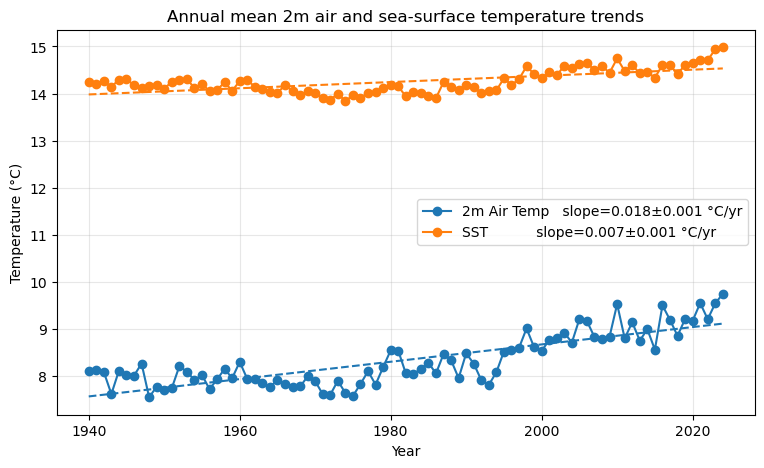

In [43]:
# Importing relevant modules
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# Loading dataset (t2m + sst)
ds = xr.open_dataset(file_path_b)

# Def linear model
def linear_model(x, m, b):
    return m * x + b

# Extracting arrays
time_index = pd.to_datetime(ds["valid_time"].values)

t2m = ds["t2m"].values
sst = ds["sst"].values

# Monthly avg in kelvin
t2m_monthly_K = np.nanmean(t2m, axis=(1, 2))
sst_monthly_K = np.nanmean(sst, axis=(1, 2))

# Converting to celsius
t2m_monthly = t2m_monthly_K - 273.15
sst_monthly = sst_monthly_K - 273.15

# Annual avgs
n_months = len(time_index)
n_years  = n_months // 12
# Trimming any incomplete years
t2m_trim = t2m_monthly[:n_years * 12].reshape(n_years, 12).mean(axis=1)
sst_trim = sst_monthly[:n_years * 12].reshape(n_years, 12).mean(axis=1)

# Creating xaxis (years)
y0 = int(time_index[0].year)
years = np.arange(y0, y0 + n_years).astype(float)

# Fitting func
def fit_series(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x_fit, y_fit = x[mask], y[mask]
    popt, pcov = curve_fit(linear_model, x_fit, y_fit)  # no sigma
    m, b = popt
    m_se = float(np.sqrt(pcov[0, 0]))  # standard error on slope
    return m, b, m_se, x_fit, y_fit

# Running linear fits
mT, bT, seT, xT, yT = fit_series(years, t2m_trim)
mS, bS, seS, xS, yS = fit_series(years, sst_trim)

# Plotting on same axes
fig, ax = plt.subplots(figsize=(9, 5))

# 2m air temperature
lnT, = ax.plot(xT, yT, "o-", label=f"2m Air Temp   slope={mT:.3f}±{seT:.3f} °C/yr")
ax.plot(xT, linear_model(xT, mT, bT), "--", color=lnT.get_color())

# Sea-surface temperature
lnS, = ax.plot(xS, yS, "o-", label=f"SST           slope={mS:.3f}±{seS:.3f} °C/yr")
ax.plot(xS, linear_model(xS, mS, bS), "--", color=lnS.get_color())

ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Annual mean 2m air and sea-surface temperature trends")
ax.grid(True, alpha=0.3)
ax.legend()

plt.show()


Over the whole area we can see that sea-surface temp is consistently ~5 or 6 degrees warmer than th 2m air temp (perhaps due to the large heat capacity of the ocean?).

As above I then zoomed into smaller sections of the atlantic. I decided to seperate it into quadrants and look at each individually:

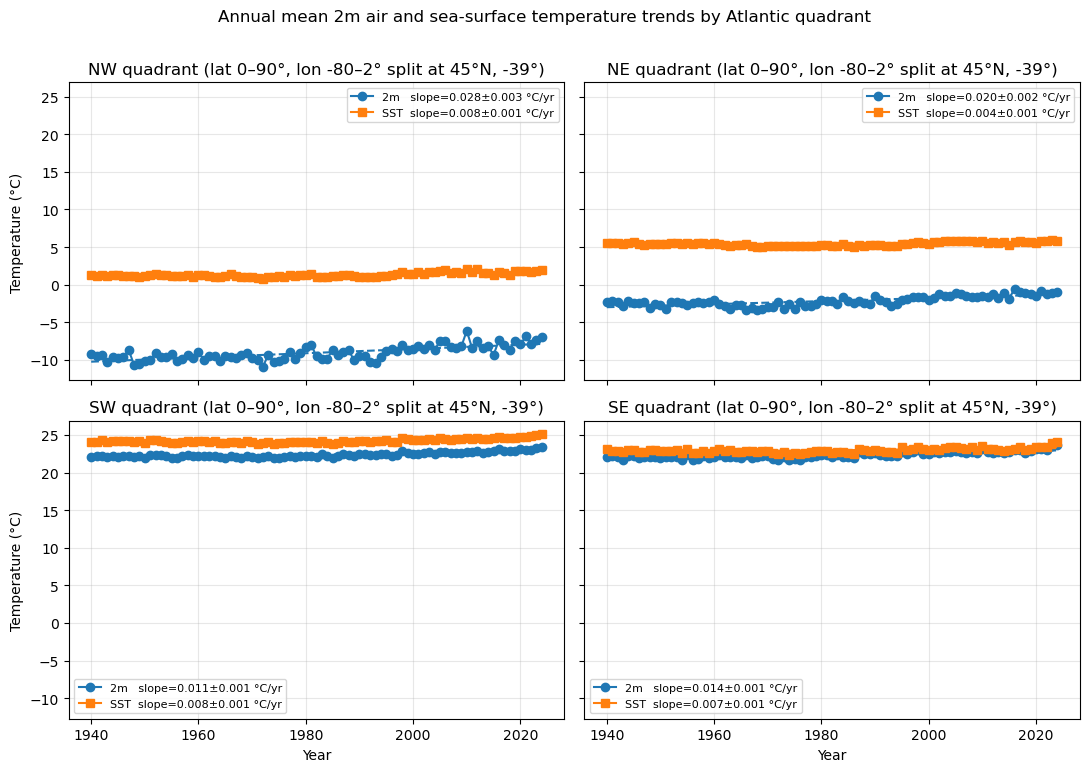

In [44]:
# Importing relevant modules
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# Loading dataset
ds = xr.open_dataset(file_path_b)

# Extracting variables
time_index = pd.to_datetime(ds["valid_time"].values)
lat = ds["latitude"].values
lon = ds["longitude"].values
t2m = ds["t2m"].values
sst = ds["sst"].values

# Choosing area
LON_MIN, LON_MAX = -80.0, 2.0
LAT_MIN, LAT_MAX = 0.0, 90.0

# Restricting to chosen area
lat_mask = (lat >= LAT_MIN) & (lat <= LAT_MAX)
lon_mask = (lon >= LON_MIN) & (lon <= LON_MAX)

lat_sub = lat[lat_mask]
lon_sub = lon[lon_mask]

t2m_sub = t2m[:, lat_mask, :][:, :, lon_mask]
sst_sub = sst[:, lat_mask, :][:, :, lon_mask]

# Converting to celsius
t2m_sub_C = t2m_sub - 273.15
sst_sub_C = sst_sub - 273.15

# Cutting up into quadrants
MID_LAT = 0.5 * (LAT_MIN + LAT_MAX)
MID_LON = 0.5 * (LON_MIN + LON_MAX)

# Quadrant masks
north_mask = lat_sub >= MID_LAT
south_mask = lat_sub <  MID_LAT
west_mask  = lon_sub <= MID_LON
east_mask  = lon_sub >  MID_LON

# Func for monthly avg for a each quadrant
def quadrant_monthly_means(field, lat_mask_part, lon_mask_part):
    # Selecting quadrant
    quad = field[:, lat_mask_part, :][:, :, lon_mask_part]
    # Monthly avg
    return np.nanmean(quad, axis=(1, 2))

# Monthly avgs in celsius for each quad
t2m_NW_monthly = quadrant_monthly_means(t2m_sub_C, north_mask, west_mask)
t2m_NE_monthly = quadrant_monthly_means(t2m_sub_C, north_mask, east_mask)
t2m_SW_monthly = quadrant_monthly_means(t2m_sub_C, south_mask, west_mask)
t2m_SE_monthly = quadrant_monthly_means(t2m_sub_C, south_mask, east_mask)

sst_NW_monthly = quadrant_monthly_means(sst_sub_C, north_mask, west_mask)
sst_NE_monthly = quadrant_monthly_means(sst_sub_C, north_mask, east_mask)
sst_SW_monthly = quadrant_monthly_means(sst_sub_C, south_mask, west_mask)
sst_SE_monthly = quadrant_monthly_means(sst_sub_C, south_mask, east_mask)

# Annual avgs (trimming incomplete final year)
n_months = len(time_index)
n_years  = n_months // 12

def to_annual(series_monthly):
    return series_monthly[:n_years * 12].reshape(n_years, 12).mean(axis=1)

t2m_NW_annual = to_annual(t2m_NW_monthly)
t2m_NE_annual = to_annual(t2m_NE_monthly)
t2m_SW_annual = to_annual(t2m_SW_monthly)
t2m_SE_annual = to_annual(t2m_SE_monthly)

sst_NW_annual = to_annual(sst_NW_monthly)
sst_NE_annual = to_annual(sst_NE_monthly)
sst_SW_annual = to_annual(sst_SW_monthly)
sst_SE_annual = to_annual(sst_SE_monthly)

# Creating xaxis (years)
y0 = int(time_index[0].year)
years = np.arange(y0, y0 + n_years).astype(float)

# Linear func
def linear_model(x, m, b):
    return m * x + b

# Fitting func
def fit_series(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x_fit, y_fit = x[mask], y[mask]
    popt, pcov = curve_fit(linear_model, x_fit, y_fit)
    m, b = popt
    m_se = float(np.sqrt(pcov[0, 0]))
    return m, b, m_se, x_fit, y_fit

# Running fits for each quad and var
quads = {
    "NW": (t2m_NW_annual, sst_NW_annual),
    "NE": (t2m_NE_annual, sst_NE_annual),
    "SW": (t2m_SW_annual, sst_SW_annual),
    "SE": (t2m_SE_annual, sst_SE_annual),
}

# Creating fig
fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharex=True, sharey=True)
axes_dict = {
    "NW": axes[0, 0],
    "NE": axes[0, 1],
    "SW": axes[1, 0],
    "SE": axes[1, 1],
}

for name, (t2m_ann, sst_ann) in quads.items():
    ax = axes_dict[name]

    # Fit 2m
    mT, bT, seT, xT, yT = fit_series(years, t2m_ann)
    # Fit SST
    mS, bS, seS, xS, yS = fit_series(years, sst_ann)

    # Plotting 2m annual avg + trend
    lnT, = ax.plot(xT, yT, "o-", label=f"2m   slope={mT:.3f}±{seT:.3f} °C/yr")
    ax.plot(xT, linear_model(xT, mT, bT), "--", color=lnT.get_color())

    # Plottnig SST annual avg + trend
    lnS, = ax.plot(xS, yS, "s-", label=f"SST  slope={mS:.3f}±{seS:.3f} °C/yr")
    ax.plot(xS, linear_model(xS, mS, bS), "--", color=lnS.get_color())

    ax.set_title(f"{name} quadrant (lat {LAT_MIN:.0f}–{LAT_MAX:.0f}°, lon {LON_MIN:.0f}–{LON_MAX:.0f}° split at {MID_LAT:.0f}°N, {MID_LON:.0f}°)")

    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

# Lables
for ax in axes[1, :]:
    ax.set_xlabel("Year")
for ax in axes[:, 0]:
    ax.set_ylabel("Temperature (°C)")

fig.suptitle("Annual mean 2m air and sea-surface temperature trends by Atlantic quadrant",
             fontsize=12, y=0.96)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


We can see that both values vary significantly depending on which quadrant we look at, with the NW 2m temp seeing the steepest slope.

I then looked into how the seasons effect both values:

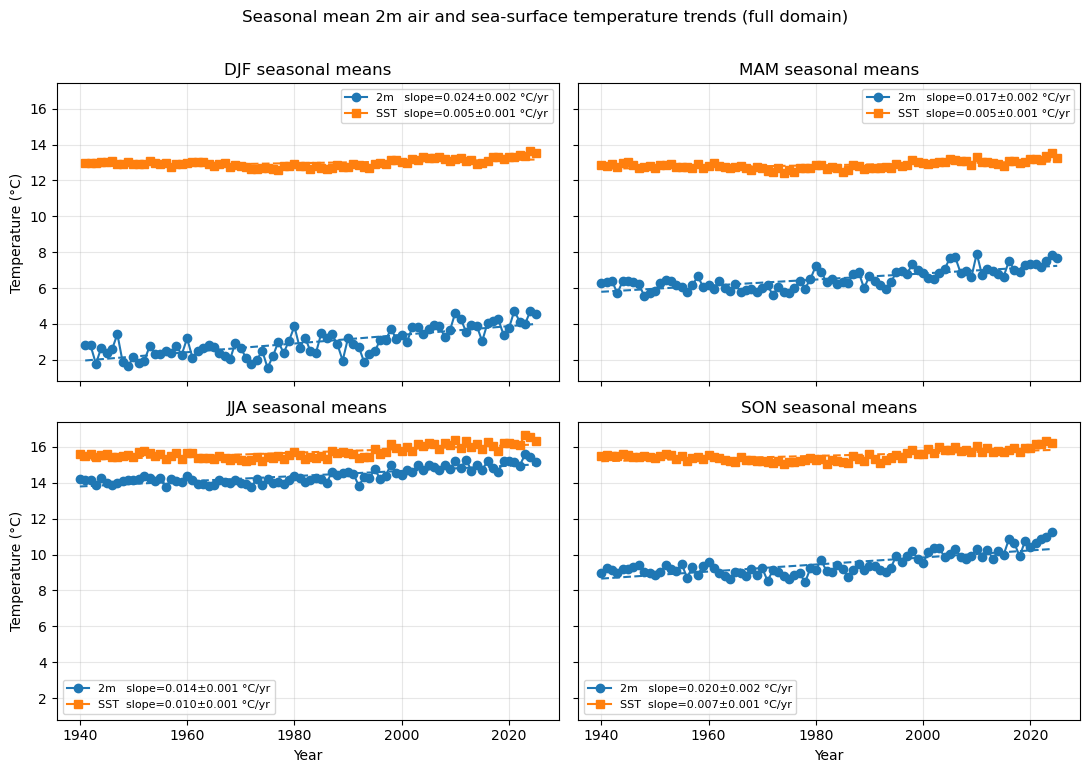

In [45]:
# Importing relevant modules
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# Loading dataset
ds = xr.open_dataset(file_path_b)

# Linear Func
def linear_model(x, m, b):
    return m * x + b

# Extracting arrays
time_index = pd.to_datetime(ds["valid_time"].values)
t2m = ds["t2m"].values  # (time, lat, lon)
sst = ds["sst"].values  # (time, lat, lon)

# Monthly avgs in Kelvin
t2m_monthly_K = np.nanmean(t2m, axis=(1, 2))
sst_monthly_K = np.nanmean(sst, axis=(1, 2))

# Converting to celsius
t2m_monthly = t2m_monthly_K - 273.15
sst_monthly = sst_monthly_K - 273.15

# Putting data in dataframe
df = pd.DataFrame({
    "time":  time_index,
    "t2m":   t2m_monthly,
    "sst":   sst_monthly,
})
df["year"]  = df["time"].dt.year
df["month"] = df["time"].dt.month

# Function for seasonal time series
def seasonal_timeseries(df, months, djf=False):
    df_seas = df[df["month"].isin(months)].copy()

    if djf:
        # Dec going to next years djf
        df_seas["season_year"] = df_seas["year"]
        df_seas.loc[df_seas["month"] == 12, "season_year"] += 1
    else:
        df_seas["season_year"] = df_seas["year"]

    # Grouping by season year and avg
    grouped = df_seas.groupby("season_year").agg(
        t2m=("t2m", "mean"),
        sst=("sst", "mean"),
        n_months=("month", "count"),
    )

    # Only keeping complete seasons (3 months)
    grouped = grouped[grouped["n_months"] == 3]

    years = grouped.index.values.astype(float)
    t2m_season = grouped["t2m"].values
    sst_season = grouped["sst"].values

    return years, t2m_season, sst_season

# Making seasonal timeseries
years_DJF, t2m_DJF, sst_DJF = seasonal_timeseries(df, [12, 1, 2], djf=True)
years_MAM, t2m_MAM, sst_MAM = seasonal_timeseries(df, [3, 4, 5], djf=False)
years_JJA, t2m_JJA, sst_JJA = seasonal_timeseries(df, [6, 7, 8], djf=False)
years_SON, t2m_SON, sst_SON = seasonal_timeseries(df, [9, 10, 11], djf=False)

# Helper for linear fit (no sigma)
def fit_series(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x_fit, y_fit = x[mask], y[mask]
    popt, pcov = curve_fit(linear_model, x_fit, y_fit)  # no sigma
    m, b = popt
    m_se = float(np.sqrt(pcov[0, 0]))  # standard error on slope
    return m, b, m_se, x_fit, y_fit

# Seasonal series for looping
seasons = {
    "DJF": (years_DJF, t2m_DJF, sst_DJF),
    "MAM": (years_MAM, t2m_MAM, sst_MAM),
    "JJA": (years_JJA, t2m_JJA, sst_JJA),
    "SON": (years_SON, t2m_SON, sst_SON),
}

# Fig layout
fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharex=True, sharey=True)
axes_grid = {
    "DJF": axes[0, 0],
    "MAM": axes[0, 1],
    "JJA": axes[1, 0],
    "SON": axes[1, 1],
}

for name, (yrs, t2m_seas, sst_seas) in seasons.items():
    ax = axes_grid[name]

    # Fitting 2m
    mT, bT, seT, xT, yT = fit_series(yrs, t2m_seas)
    # Fitting SST
    mS, bS, seS, xS, yS = fit_series(yrs, sst_seas)

    # 2m annual seasonal avg + trend
    lnT, = ax.plot(xT, yT, "o-", label=f"2m   slope={mT:.3f}±{seT:.3f} °C/yr")
    ax.plot(xT, linear_model(xT, mT, bT), "--", color=lnT.get_color())

    # SST annual seasonal avg + trend
    lnS, = ax.plot(xS, yS, "s-", label=f"SST  slope={mS:.3f}±{seS:.3f} °C/yr")
    ax.plot(xS, linear_model(xS, mS, bS), "--", color=lnS.get_color())

    ax.set_title(f"{name} seasonal means")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

# Axis labels
for ax in axes[1, :]:
    ax.set_xlabel("Year")
for ax in axes[:, 0]:
    ax.set_ylabel("Temperature (°C)")

fig.suptitle("Seasonal mean 2m air and sea-surface temperature trends (full domain)",
             fontsize=12, y=0.96)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


It's clear that the air temperature varies much more with the seasons than the sea-surface temperature does. I'd imagine this is due to the massive heat capacity of the ocean, meaning it changes temperature very slowly.

This may play a key factor in why the south of the UK is warming faster than the north (the north has a much greater exposure to the north atlantic, which has a large heat capacity so stays cool, while the south has less exposure to the atlantic and is more influenced by european land mass, which warms faster).